## Use new harmonized data file 

From request [Rerun machine learning using the attached spreadsheet.](https://trello.com/c/IoUEsHsC)

## Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    print("TRAINNG PROBABILITIES")
    for a,b in zip(y, clf.predict_proba(X)[:,1]):
        print(a,b)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    print("TESTING PROBABILITIES")
    for a,b in zip(Y_test,y_pred_prob):
        print(a,b)
    
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))
        
def print_score_summaries(scores_dict):
    for score_name in scores_dict:
        scores = scores_dict[score_name]
        print("%s\t%s\t%s" %(score_name, np.mean(scores[~np.isnan(scores)]), np.std(scores[~np.isnan(scores)])))

## Define classifier, pipeline and constants

In [2]:
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('Harmonized_Data.xlsx').drop(['UPDRS'], axis=1)
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


Best parameters set found on development set:

{'classifier__C': 4.2813323987193957e-05}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.27      1.00      0.43        55
          1       0.00      0.00      0.00       146

avg / total       0.07      0.27      0.12       201


Confusion matrix, without normalization
[[ 55   0]
 [146   0]]

recall	0.0


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


precision	0.0
auc	0.5
specificity	1.0
npv	0.273631840796
accuracy	0.273631840796
weighted_sensitivity	0.0
weighted_ppv	nan
weighted_specificity	1.0
weighted_npv	0.5


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in double_scalars


weighted_accuracy	0.5
TRAINNG PROBABILITIES
1 0.728395840121
1 0.728989272291
1 0.729478845956
1 0.729418539209
1 0.724997180954
0 0.730316776969
1 0.728785393354
1 0.730094369305
0 0.730441545144
0 0.726597059291
1 0.72563937497
1 0.7299174438
0 0.731422197451
1 0.731091982641
1 0.729255162334
0 0.730804906512
1 0.723824426327
1 0.724447758521
0 0.730417749505
0 0.730183000191
1 0.726659092343
1 0.730128298789
1 0.733352020987
1 0.725656748031
1 0.731552021414
1 0.726767164225
1 0.728602926405
1 0.730901373381
0 0.730927987458
1 0.726876367624
1 0.728198714492
0 0.727497820214
1 0.731423141201
1 0.729134384524
0 0.728996248598
1 0.729278564371
1 0.728641811629
1 0.729856475512
1 0.729801856125
1 0.729058986196
0 0.729520089126
1 0.728208279852
0 0.731063065941
1 0.727505699502
0 0.72882830922
0 0.727683581756
1 0.728696304943
1 0.726680558457
1 0.726589858175
1 0.724626830722
1 0.727938142044
1 0.732174333812
1 0.731944536374
0 0.730050118058
1 0.731275017113
1 0.732046183429
1 0.7289

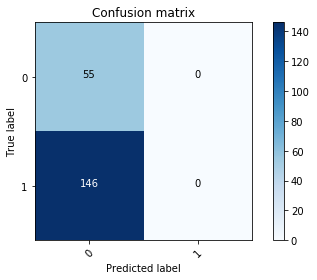

In [3]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [4]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
print_score_summaries(scores)

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\ana

fit_time	0.315831136703	0.00945080204624
score_time	0.173843860626	0.0182275702476
test_recall	1.0	0.0
train_recall	1.0	0.0
test_precision	0.721606312747	0.00135875441804
train_precision	0.721598520249	0.00033861715681
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	0.0	0.0
train_specificity	0.0	0.0
test_npv	nan	nan
train_npv	nan	nan
test_accuracy	0.721606312747	0.00135875441804
train_accuracy	0.721598520249	0.00033861715681
test_weighted_sensitivity	1.0	0.0
train_weighted_sensitivity	1.0	0.0
test_weighted_ppv	0.5	0.0
train_weighted_ppv	0.5	0.0
test_weighted_specificity	0.0	0.0
train_weighted_specificity	0.0	0.0
test_weighted_npv	nan	nan
train_weighted_npv	nan	nan
test_weighted_accuracy	0.5	0.0
train_weighted_accuracy	0.5	0.0


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


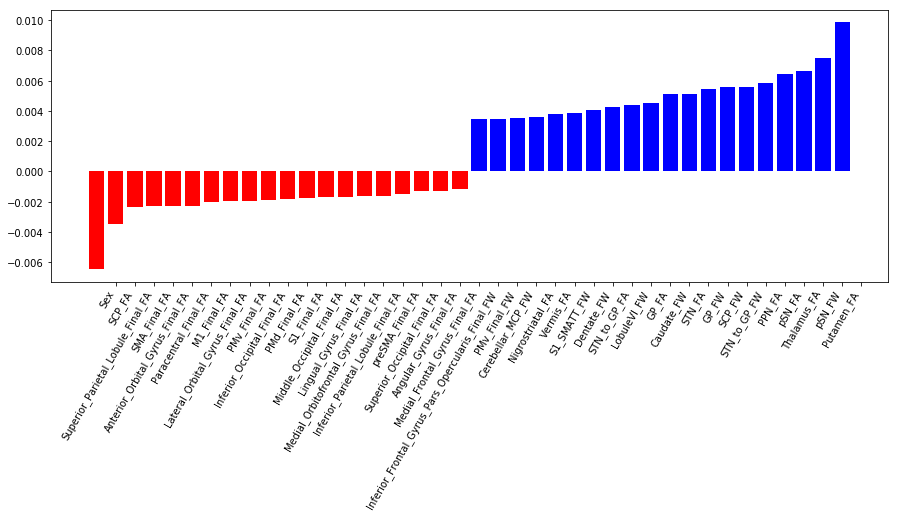

Age	0.00253059715854
Sex	-0.00646942402421
aSN_FA	0.00138531547923
Caudate_FA	0.000258867308822
CC2_FA	0.00175828172517
GP_FA	0.00449136199432
LobuleVI_FA	0.000513825294792
LobuleV_FA	-9.33922778887e-05
MCP_FA	0.00183213751312
pSN_FA	0.00642149031301
Putamen_FA	0.00986545438059
SCP_FA	-0.00346430757894
STN_FA	0.005145384433
Thalamus_FA	0.0066673190554
Vermis_FA	0.00380648676443
RN_FA	-0.000804685081196
PPN_FA	0.00582204249791
Dentate_FA	0.000755227552375
CC1_FA	-0.000208033593877
aSN_FW	0.00315332843981
Caudate_FW	0.00512977100684
CC2_FW	0.00273332297764
GP_FW	0.00542817590042
LobuleVI_FW	0.00435646514793
LobuleV_FW	0.00326755601238
MCP_FW	0.00145537426529
pSN_FW	0.00749075990481
Putamen_FW	0.0033421782727
SCP_FW	0.00556790788931
STN_FW	0.00253917516658
Thalamus_FW	0.00250386821801
Vermis_FW	0.00166953738269
RN_FW	0.0031342316847
PPN_FW	0.000671956492978
Dentate_FW	0.00405057571807
CC1_FW	0.00118811709034
Angular_Gyrus_Final_FA	-0.00126863991437
Anterior_Orbital_Gyrus_Final_FA	-0.00227

In [5]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.27      1.00      0.43        55
          1       0.00      0.00      0.00       146

avg / total       0.07      0.27      0.12       201

TESTING PROBABILITIES
1 0.728388922634
1 0.726148141251
1 0.724233761921
1 0.729622596045
0 0.73127857917
0 0.727918047867
1 0.728478172434
1 0.731853018661
1 0.727480623119
1 0.727639022711
0 0.730578900923
0 0.72911352256
1 0.727514052626
0 0.731261768418
1 0.728144670947
1 0.730291323973
1 0.728528704325
0 0.728792130546
1 0.731347182727
1 0.728439281679
1 0.72685974336
1 0.729756359126
1 0.732267483554
0 0.727970462746
0 0.730431845421
1 0.728864237743
1 0.727833791654
1 0.731292117022
1 0.725325929747
1 0.728923540333
1 0.726231539465
0 0.732492889006
0 0.730094596999
1 0.729770592773
1 0.726826713062
0 0.728238716018
0 0.728550757386
1 0.729239211805
1 0.730023765633
1 0.725563128312
1 0.731650217993
1 0.730999633437
0 0.729897226589
1 0.727100998342
1 0.726948315188
0

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


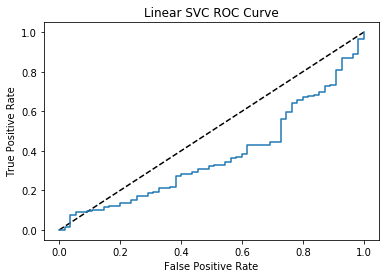

0.0 0.0
0.0181818181818 0.0
0.0181818181818 0.013698630137
0.0363636363636 0.013698630137
0.0363636363636 0.0753424657534
0.0545454545455 0.0753424657534
0.0545454545455 0.0890410958904
0.0909090909091 0.0890410958904
0.0909090909091 0.0958904109589
0.109090909091 0.0958904109589
0.109090909091 0.102739726027
0.145454545455 0.102739726027
0.145454545455 0.116438356164
0.163636363636 0.116438356164
0.163636363636 0.123287671233
0.2 0.123287671233
0.2 0.13698630137
0.236363636364 0.13698630137
0.236363636364 0.150684931507
0.254545454545 0.150684931507
0.254545454545 0.171232876712
0.290909090909 0.171232876712
0.290909090909 0.184931506849
0.309090909091 0.184931506849
0.309090909091 0.191780821918
0.327272727273 0.191780821918
0.327272727273 0.212328767123
0.363636363636 0.212328767123
0.363636363636 0.219178082192
0.381818181818 0.219178082192
0.381818181818 0.27397260274
0.4 0.27397260274
0.4 0.280821917808
0.436363636364 0.280821917808
0.436363636364 0.294520547945
0.454545454545 0.

In [6]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.93      0.91      0.92       105
          1       0.79      0.82      0.80        40

avg / total       0.89      0.89      0.89       145


Confusion matrix, without normalization
[[96  9]
 [ 7 33]]

recall	0.825
precision	0.785714285714
auc	0.869642857143
specificity	0.914285714286
npv	0.932038834951
accuracy	0.889655172414
weighted_sensitivity	0.825
weighted_ppv	0.905882352941
weighted_specificity	0.914285714286
weighted_npv	0.839344262295
weighted_accuracy	0.869642857143
TRAINNG PROBABILITIES
0 0.186024911252
0 0.337793934347
0 0.222362716108
1 0.188921612557
0 0.165959074884
1 0.846496362221
0 0.344115272741
1 0.842531928358
0 0.0411751014836
0 0.0521865471005
0 0.132112129507
0

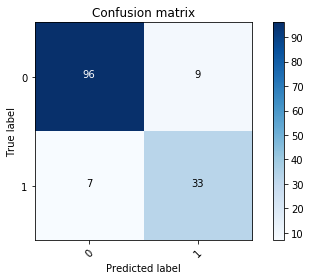

In [7]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [8]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0975923061371	0.00427473191858
score_time	0.0513978481293	0.00998648244855
test_recall	0.751596638655	0.0427221469198
train_recall	0.823751433636	0.0180754444209
test_precision	0.747162283251	0.0623067332818
train_precision	0.834672828931	0.0111969572997
test_auc	0.820438487952	0.0294999793827
train_auc	0.877081794691	0.00910979313862
test_specificity	0.889280337248	0.0343697204406
train_specificity	0.930412155745	0.00579750293785
test_npv	0.893681318681	0.017776893033
train_npv	0.925353941403	0.00717725661086
test_accuracy	0.848120298825	0.0290460296888
train_accuracy	0.898534475504	0.00635710624967
test_weighted_sensitivity	0.751596638655	0.0427221469198
train_weighted_sensitivity	0.823751433636	0.0180754444209
test_weighted_ppv	0.872464889706	0.0364613143805
train_weighted_ppv	0.922123178513	0.00589697532846
test_weighted_specificity	0.889280337248	0.0343697204406
train_weighted_specificity	0.930412155745	0.00579750293785
test_weighted_npv	0.782480447994	0.0318344721409
t

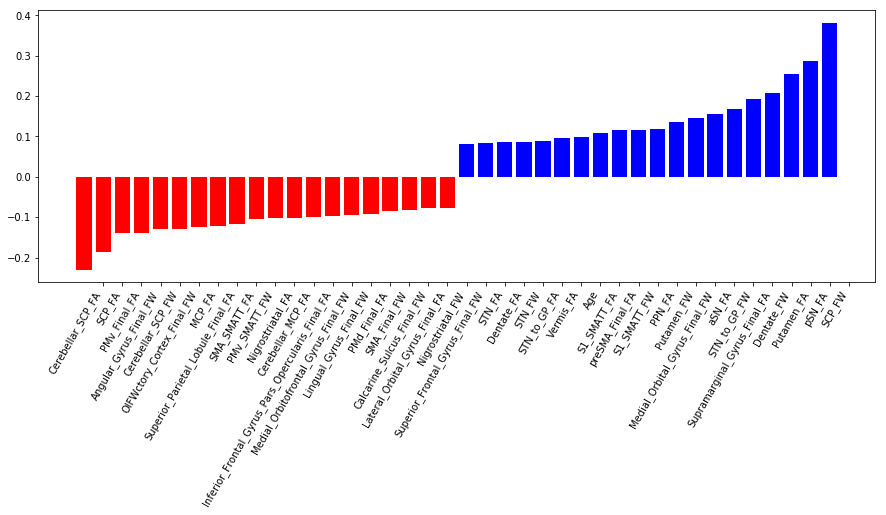

Age	0.0996511417445
Sex	0.0
aSN_FA	0.155313908874
Caudate_FA	0.00599021113917
CC2_FA	0.0312998399793
GP_FA	-0.028233900438
LobuleVI_FA	0.0409413765853
LobuleV_FA	-0.0661669152019
MCP_FA	-0.124039262464
pSN_FA	0.287397836039
Putamen_FA	0.253875084193
SCP_FA	-0.187119813757
STN_FA	0.0841475299993
Thalamus_FA	0.0383212204412
Vermis_FA	0.0961273216423
RN_FA	0.000108732118878
PPN_FA	0.119083771607
Dentate_FA	0.0852154358363
CC1_FA	-0.0187322929549
aSN_FW	-0.00242937258303
Caudate_FW	-0.0363409252236
CC2_FW	0.0738297628184
GP_FW	0.0590365629133
LobuleVI_FW	0.0818531251937
LobuleV_FW	0.0449090177601
MCP_FW	0.0701308026645
pSN_FW	0.0617173928623
Putamen_FW	0.135662036858
SCP_FW	0.381703816381
STN_FW	0.0860993247815
Thalamus_FW	0.0535656618756
Vermis_FW	0.00789460080912
RN_FW	-0.0121769478106
PPN_FW	-0.0651426555576
Dentate_FW	0.208572399477
CC1_FW	0.00112228580608
Angular_Gyrus_Final_FA	-0.0113933939488
Anterior_Orbital_Gyrus_Final_FA	0.0468530020359
Calcarine_Sulcus_Final_FA	-0.0292394344842


In [9]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.93      0.91      0.92       105
          1       0.79      0.82      0.80        40

avg / total       0.89      0.89      0.89       145

TESTING PROBABILITIES
1 0.166885366042
0 0.0302214956264
0 0.0868034657339
0 0.150237666442
0 0.134552605973
0 0.283860600309
0 0.141110967036
0 0.0601567878198
0 0.142441037385
0 0.0447636173888
1 0.9965504643
0 0.0823835406331
1 0.632117212993
0 0.0366565744359
0 0.0311950378052
1 0.992439999814
1 0.972576537765
0 0.286658772948
0 0.160087590729
1 0.528032021101
0 0.0977627248844
0 0.133853036173
0 0.259059242407
0 0.149435981895
0 0.029932496257
1 0.945016654412
1 0.332240189652
0 0.147091633634
0 0.145060176896
0 0.251429873964
0 0.0754909891699
1 0.887307402164
1 0.655536923854
1 0.355994793765
1 0.848458040192
1 0.88470434732
0 0.103398586007
1 0.799624816581
1 0.999988192662
0 0.117675214069
0 0.353064242022
0 0.233907545282
0 0.0755999555315
0 0.312619828748
0 0.0701

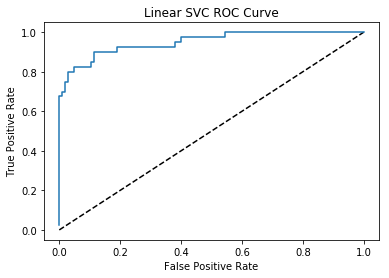

0.0 0.025
0.0 0.675
0.00952380952381 0.675
0.00952380952381 0.7
0.0190476190476 0.7
0.0190476190476 0.75
0.0285714285714 0.75
0.0285714285714 0.8
0.047619047619 0.8
0.047619047619 0.825
0.104761904762 0.825
0.104761904762 0.85
0.114285714286 0.85
0.114285714286 0.9
0.190476190476 0.9
0.190476190476 0.925
0.380952380952 0.925
0.380952380952 0.95
0.4 0.95
0.4 0.975
0.542857142857 0.975
0.542857142857 1.0
1.0 1.0


In [10]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished


Best parameters set found on development set:

{'classifier__C': 0.00078475997035146064}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.95      0.94      0.94       131
          1       0.47      0.50      0.48        14

avg / total       0.90      0.90      0.90       145


Confusion matrix, without normalization
[[123   8]
 [  7   7]]

recall	0.5
precision	0.466666666667
auc	0.719465648855
specificity	0.93893129771
npv	0.946153846154
accuracy	0.896551724138
weighted_sensitivity	0.5
weighted_ppv	0.891156462585
weighted_specificity	0.93893129771
weighted_npv	0.652519893899
weighted_accuracy	0.719465648855
TRAINNG PROBABILITIES
0 0.0684939363501
0 0.164086943787
0 0.0371450894329
1 0.115006442338
0 0.0552892331005
0 0.115430713917
0 0.0535969143851
1 0.0719901837987
0 0.085986125067
0 0.0257621236959
0 0.116812245

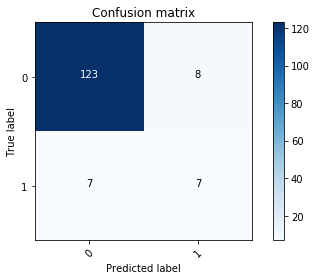

In [11]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [12]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.186524009705	0.0488877136043
score_time	0.0804164409637	0.00862622713687
test_recall	0.457142857143	0.0968904283304
train_recall	0.489285714286	0.0242226070826
test_precision	0.596406926407	0.0737941739253
train_precision	0.604244573394	0.0383907869976
test_auc	0.706954266855	0.0466357102385
train_auc	0.722541276953	0.0142014707613
test_specificity	0.956765676568	0.0147133095837
train_specificity	0.95579683962	0.00514313445987
test_npv	0.92781074189	0.0114025025456
train_npv	0.931542916534	0.00330607649242
test_accuracy	0.896371814093	0.0144296598319
train_accuracy	0.899395806956	0.00704031941592
test_weighted_sensitivity	0.457142857143	0.0968904283304
train_weighted_sensitivity	0.489285714286	0.0242226070826
test_weighted_ppv	0.912620707425	0.0229856046021
train_weighted_ppv	0.916762646757	0.0121011255997
test_weighted_specificity	0.956765676568	0.0147133095837
train_weighted_specificity	0.95579683962	0.00514313445987
test_weighted_npv	0.640557050145	0.0386918303127
train_w

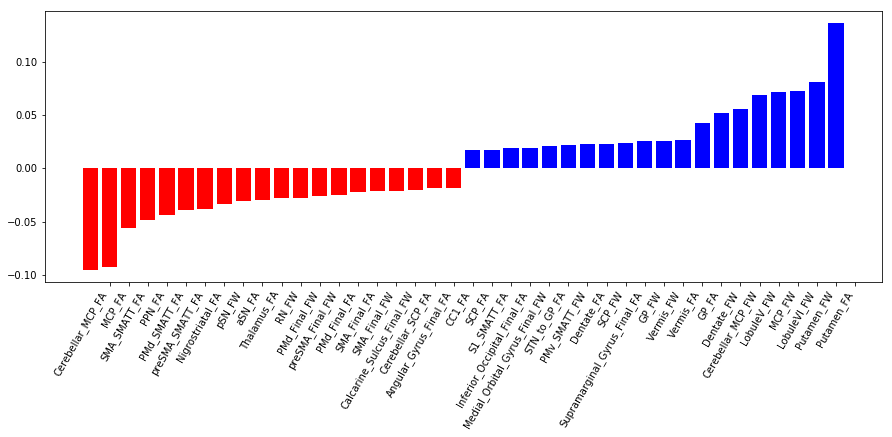

Age	0.0160316264382
Sex	0.0
aSN_FA	-0.0305343696867
Caudate_FA	0.0118753484241
CC2_FA	0.00834713652482
GP_FA	0.0429210670496
LobuleVI_FA	-0.0177192897188
LobuleV_FA	0.0111555355004
MCP_FA	-0.0930873125314
pSN_FA	0.0112141861586
Putamen_FA	0.136618431615
SCP_FA	0.0171788145781
STN_FA	-0.00588745740951
Thalamus_FA	-0.0300393584231
Vermis_FA	0.0263176052914
RN_FA	0.00603086869173
PPN_FA	-0.0484066296215
Dentate_FA	0.0226523456404
CC1_FA	-0.0181146456243
aSN_FW	-0.0104543929161
Caudate_FW	0.00530198579614
CC2_FW	-0.0115758835013
GP_FW	0.0253022317753
LobuleVI_FW	0.0728661858664
LobuleV_FW	0.0688886305522
MCP_FW	0.0716555918855
pSN_FW	-0.0333505836564
Putamen_FW	0.081263392539
SCP_FW	0.0229717340507
STN_FW	-0.00652119942887
Thalamus_FW	0.00374252447642
Vermis_FW	0.0257898957945
RN_FW	-0.0278530221673
PPN_FW	-0.0178752578288
Dentate_FW	0.0524020899511
CC1_FW	-0.0126457642209
Angular_Gyrus_Final_FA	-0.0185787539356
Anterior_Orbital_Gyrus_Final_FA	0.000537745522484
Calcarine_Sulcus_Final_FA	0.

In [13]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.95      0.94      0.94       131
          1       0.47      0.50      0.48        14

avg / total       0.90      0.90      0.90       145

TESTING PROBABILITIES
1 0.031107186704
0 0.0296658400797
0 0.117558965348
0 0.218782697749
0 0.0654394702844
0 0.0793667193573
0 0.195941915433
0 0.0336591598389
0 0.0798125833594
0 0.0181515706209
0 0.505034107876
0 0.039888436087
1 0.778514980545
0 0.0597142115891
0 0.0963144269117
1 0.984738812113
0 0.136046454539
0 0.0945188003389
0 0.0393066438699
0 0.161296382794
0 0.0633585569839
0 0.0600970250353
0 0.0910647979481
0 0.0625141510383
0 0.0527511016219
0 0.088688635379
0 0.151964521895
0 0.103547536745
0 0.0937805143055
0 0.286042696448
0 0.0474691724655
1 0.395958427423
0 0.185974946719
0 0.0483833335187
0 0.14281276857
1 0.729282753793
0 0.136344056969
1 0.406613341813
1 0.973264518325
0 0.106142859311
0 0.167024991304
0 0.21829281296
0 0.074293567309
0 0.082343731795

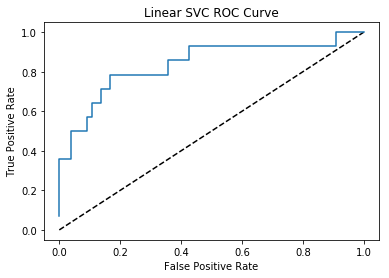

0.0 0.0714285714286
0.0 0.357142857143
0.0381679389313 0.357142857143
0.0381679389313 0.5
0.0916030534351 0.5
0.0916030534351 0.571428571429
0.106870229008 0.571428571429
0.106870229008 0.642857142857
0.137404580153 0.642857142857
0.137404580153 0.714285714286
0.167938931298 0.714285714286
0.167938931298 0.785714285714
0.358778625954 0.785714285714
0.358778625954 0.857142857143
0.427480916031 0.857142857143
0.427480916031 0.928571428571
0.908396946565 0.928571428571
0.908396946565 1.0
1.0 1.0


In [14]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished


Best parameters set found on development set:

{'classifier__C': 0.0069519279617756054}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.96      0.91      0.93       119
          1       0.66      0.81      0.72        26

avg / total       0.90      0.89      0.89       145


Confusion matrix, without normalization
[[108  11]
 [  5  21]]

recall	0.807692307692
precision	0.65625
auc	0.857627666451
specificity	0.90756302521
npv	0.955752212389
accuracy	0.889655172414
weighted_sensitivity	0.807692307692
weighted_ppv	0.897307001795
weighted_specificity	0.90756302521
weighted_npv	0.825154275639
weighted_accuracy	0.857627666451
TRAINNG PROBABILITIES
0 0.0440551874771
0 0.105421882772
0 0.188790854978
0 0.0440102795653
0 0.100581880556
1 0.723955403265
0 0.165959916729
0 0.937030776207
0 0.00522681993468
0 0.0235352815718


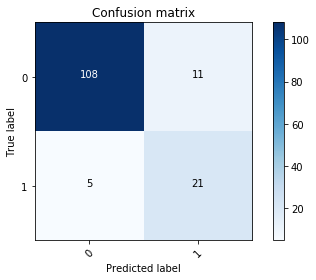

In [15]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [16]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0758384227753	0.00929415797585
score_time	0.0413031101227	0.0074337559202
test_recall	0.82619047619	0.0462665059104
train_recall	0.895680282104	0.011938391458
test_precision	0.788525252525	0.0905201466486
train_precision	0.799253824161	0.0185183973554
test_auc	0.887897869674	0.0283971893017
train_auc	0.923417568874	0.00425336961085
test_specificity	0.949605263158	0.0243033119045
train_specificity	0.951154855643	0.00612645878867
test_npv	0.961766521941	0.0106043305292
train_npv	0.97682511258	0.00259569641626
test_accuracy	0.927538410282	0.0232666875606
train_accuracy	0.941275860941	0.00374894646827
test_weighted_sensitivity	0.82619047619	0.0462665059104
train_weighted_sensitivity	0.895680282104	0.011938391458
test_weighted_ppv	0.942825309038	0.0277234265992
train_weighted_ppv	0.948370055239	0.00557745435314
test_weighted_specificity	0.949605263158	0.0243033119045
train_weighted_specificity	0.951154855643	0.00612645878867
test_weighted_npv	0.846528711397	0.0362662058718
train_

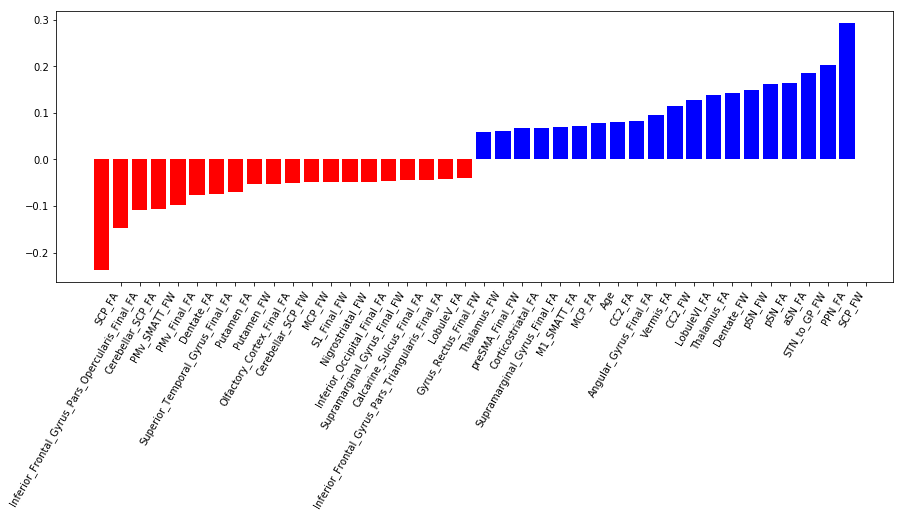

Age	0.0786081397521
Sex	0.0
aSN_FA	0.163625794599
Caudate_FA	-0.00314978722517
CC2_FA	0.0795439109147
GP_FA	0.000305940290971
LobuleVI_FA	0.128910914687
LobuleV_FA	-0.0410780441773
MCP_FA	0.0724450218885
pSN_FA	0.161723716095
Putamen_FA	-0.0691843548108
SCP_FA	-0.237554853623
STN_FA	0.019552874537
Thalamus_FA	0.1389095948
Vermis_FA	0.0962130729382
RN_FA	-0.0117597460131
PPN_FA	0.204070706106
Dentate_FA	-0.0771665859725
CC1_FA	0.0018673443759
aSN_FW	-0.0240705472083
Caudate_FW	0.0136300531976
CC2_FW	0.114172199882
GP_FW	0.00141962447729
LobuleVI_FW	-0.0187680294111
LobuleV_FW	-0.0363728903607
MCP_FW	-0.0493641466018
pSN_FW	0.149928143026
Putamen_FW	-0.05341341105
SCP_FW	0.293564951019
STN_FW	0.0592890408114
Thalamus_FW	0.0596302865981
Vermis_FW	0.0246365354614
RN_FW	0.0446532946892
PPN_FW	0.0204399208305
Dentate_FW	0.142862499023
CC1_FW	-0.0354360058288
Angular_Gyrus_Final_FA	0.0820665309354
Anterior_Orbital_Gyrus_Final_FA	0.0222541887427
Calcarine_Sulcus_Final_FA	-0.0446948739871
Cuneu

In [17]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.96      0.91      0.93       119
          1       0.66      0.81      0.72        26

avg / total       0.90      0.89      0.89       145

TESTING PROBABILITIES
0 0.0596370681001
0 0.0128279254928
0 0.010685317455
0 0.00792201553024
0 0.0254573917885
0 0.0322234683138
0 0.0216739976246
0 0.0147522331465
0 0.0163652177975
0 0.0226724065263
1 0.990584099305
0 0.0514202249589
0 0.0068657247341
0 0.00655709095278
0 0.00187537926648
0 0.0542610258183
1 0.997024370146
0 0.195360707112
0 0.11840046723
1 0.152800121285
0 0.0262337691632
0 0.0262028129467
0 0.0512117357633
0 0.013316004908
0 0.00804689649565
1 0.953864901239
1 0.109715206911
0 0.0273677889666
0 0.0367246512714
0 0.0282175254917
0 0.0135627087683
0 0.171729111569
1 0.417884644938
1 0.263547802719
1 0.741163395362
0 0.0384328416458
0 0.00485705788104
0 0.0613676254097
0 0.362923531879
0 0.00982428218316
0 0.0773007078581
0 0.0195425960754
0 0.013737948428

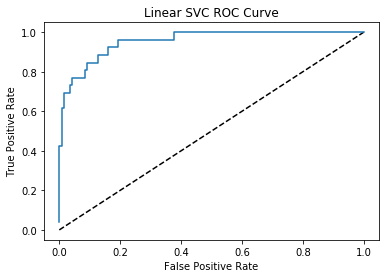

0.0 0.0384615384615
0.0 0.423076923077
0.00840336134454 0.423076923077
0.00840336134454 0.615384615385
0.0168067226891 0.615384615385
0.0168067226891 0.692307692308
0.0336134453782 0.692307692308
0.0336134453782 0.730769230769
0.0420168067227 0.730769230769
0.0420168067227 0.769230769231
0.0840336134454 0.769230769231
0.0840336134454 0.807692307692
0.0924369747899 0.807692307692
0.0924369747899 0.846153846154
0.126050420168 0.846153846154
0.126050420168 0.884615384615
0.159663865546 0.884615384615
0.159663865546 0.923076923077
0.193277310924 0.923076923077
0.193277310924 0.961538461538
0.378151260504 0.961538461538
0.378151260504 1.0
1.0 1.0


In [18]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


Best parameters set found on development set:

{'classifier__C': 0.061584821106602607}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.83      0.77      0.80        13
          1       0.90      0.93      0.92        30

avg / total       0.88      0.88      0.88        43


Confusion matrix, without normalization
[[10  3]
 [ 2 28]]

recall	0.933333333333
precision	0.903225806452
auc	0.851282051282
specificity	0.769230769231
npv	0.833333333333
accuracy	0.883720930233
weighted_sensitivity	0.933333333333
weighted_ppv	0.801762114537
weighted_specificity	0.769230769231
weighted_npv	0.920245398773
weighted_accuracy	0.851282051282
TRAINNG PROBABILITIES
1 0.777756137278
0 0.119031345382
0 0.5
1 0.712065584885
1 0.972079063635
1 0.777749062109
1 0.693301981929
0 0.227527598092
1 0.894669516918
1 0.680277706927
1 0.61103941

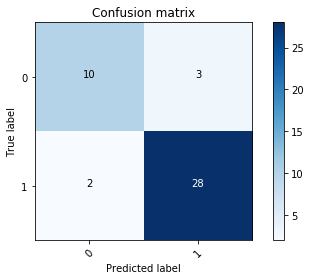

In [19]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [20]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0106988430023	0.00132578610511
score_time	0.00970320701599	0.00107864453805
test_recall	0.847894736842	0.0960638061272
train_recall	0.962088607595	0.0113931082765
test_precision	0.89619047619	0.0688354704746
train_precision	0.977041477041	0.00914987799047
test_auc	0.853471177945	0.0758183950633
train_auc	0.965192173472	0.0087124811085
test_specificity	0.859047619048	0.101087062003
train_specificity	0.968295739348	0.0131644571295
test_npv	0.809735878157	0.102599069809
train_npv	0.948438674125	0.0148983628794
test_accuracy	0.852197606315	0.0758350155547
train_accuracy	0.964694193979	0.00863484705947
test_weighted_sensitivity	0.847894736842	0.0960638061272
train_weighted_sensitivity	0.962088607595	0.0113931082765
test_weighted_ppv	0.863855002244	0.0893394700187
train_weighted_ppv	0.968259122013	0.0126796126307
test_weighted_specificity	0.859047619048	0.101087062003
train_weighted_specificity	0.968295739348	0.0131644571295
test_weighted_npv	0.85375499552	0.080881337399
train_wei

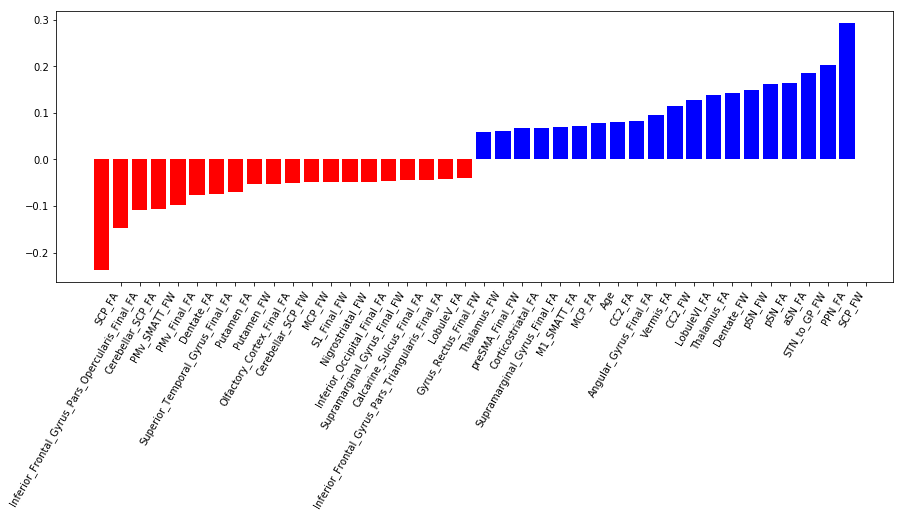

Age	0.0786081397521
Sex	0.0
aSN_FA	0.163625794599
Caudate_FA	-0.00314978722517
CC2_FA	0.0795439109147
GP_FA	0.000305940290971
LobuleVI_FA	0.128910914687
LobuleV_FA	-0.0410780441773
MCP_FA	0.0724450218885
pSN_FA	0.161723716095
Putamen_FA	-0.0691843548108
SCP_FA	-0.237554853623
STN_FA	0.019552874537
Thalamus_FA	0.1389095948
Vermis_FA	0.0962130729382
RN_FA	-0.0117597460131
PPN_FA	0.204070706106
Dentate_FA	-0.0771665859725
CC1_FA	0.0018673443759
aSN_FW	-0.0240705472083
Caudate_FW	0.0136300531976
CC2_FW	0.114172199882
GP_FW	0.00141962447729
LobuleVI_FW	-0.0187680294111
LobuleV_FW	-0.0363728903607
MCP_FW	-0.0493641466018
pSN_FW	0.149928143026
Putamen_FW	-0.05341341105
SCP_FW	0.293564951019
STN_FW	0.0592890408114
Thalamus_FW	0.0596302865981
Vermis_FW	0.0246365354614
RN_FW	0.0446532946892
PPN_FW	0.0204399208305
Dentate_FW	0.142862499023
CC1_FW	-0.0354360058288
Angular_Gyrus_Final_FA	0.0820665309354
Anterior_Orbital_Gyrus_Final_FA	0.0222541887427
Calcarine_Sulcus_Final_FA	-0.0446948739871
Cuneu

In [21]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.83      0.77      0.80        13
          1       0.90      0.93      0.92        30

avg / total       0.88      0.88      0.88        43

TESTING PROBABILITIES
0 0.0155042007375
1 0.863542379984
1 0.576331785319
0 0.715526925366
0 0.121114870239
1 0.901946626389
0 0.950932240619
0 0.333922676882
1 0.940827775896
1 0.183589248629
1 0.645042151614
1 0.885257963403
1 0.539161403856
0 0.710235423134
0 0.0538771870405
1 0.985432525853
1 0.290308262018
1 0.917229060798
1 0.862152135523
1 0.992882072046
0 0.344657359902
1 0.974683501798
1 0.71089767155
0 0.0200197151632
1 0.985399403888
1 0.836161617652
1 0.849030114937
1 0.515845609975
1 0.974948066037
1 0.92058430964
1 0.579103426335
0 0.0964482321182
1 0.752259674341
0 0.0179381484059
1 0.974165458696
0 0.0388024376292
1 0.952688780211
1 0.783184048581
1 0.846763897866
1 0.961937910573
0 0.0988005551806
1 0.968699774076
1 0.670714151338


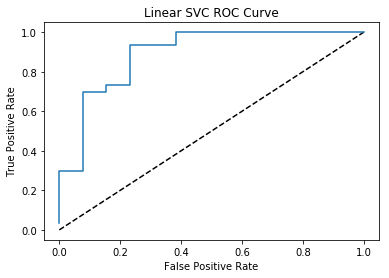

0.0 0.0333333333333
0.0 0.3
0.0769230769231 0.3
0.0769230769231 0.7
0.153846153846 0.7
0.153846153846 0.733333333333
0.230769230769 0.733333333333
0.230769230769 0.933333333333
0.384615384615 0.933333333333
0.384615384615 1.0
1.0 1.0


In [22]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


Best parameters set found on development set:

{'classifier__C': 0.061584821106602607}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.90      0.93      0.92        30
          1       0.83      0.77      0.80        13

avg / total       0.88      0.88      0.88        43


Confusion matrix, without normalization
[[28  2]
 [ 3 10]]

recall	0.769230769231
precision	0.833333333333
auc	0.851282051282
specificity	0.933333333333
npv	0.903225806452
accuracy	0.883720930233
weighted_sensitivity	0.769230769231
weighted_ppv	0.920245398773
weighted_specificity	0.933333333333
weighted_npv	0.801762114537
weighted_accuracy	0.851282051282
TRAINNG PROBABILITIES
0 0.20177853785
1 0.868735745054
1 0.470431660957
0 0.263763323861
0 0.0251622752008
0 0.201687574697
0 0.281489839605
1 0.751585854344
0 0.0942657905928
0 0.294071869144


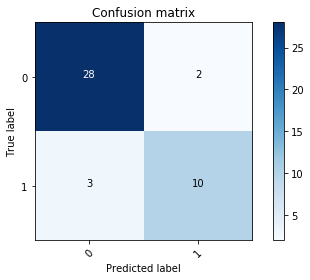

In [23]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [24]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.02091755867	0.015980433971
score_time	0.0205877780914	0.0173449658309
test_recall	0.831428571429	0.071371405696
train_recall	0.929636591479	0.0108009582615
test_precision	0.776703296703	0.0771539705842
train_precision	0.830761241447	0.0245448703999
test_auc	0.82492481203	0.0373464784823
train_auc	0.896606270423	0.0152961346551
test_specificity	0.818421052632	0.0922780334482
train_specificity	0.863575949367	0.0234878355095
test_npv	0.874920634921	0.0438899652556
train_npv	0.9446749929	0.00933620659863
test_accuracy	0.823121976063	0.0431750295873
train_accuracy	0.891163510011	0.0164401711804
test_weighted_sensitivity	0.831428571429	0.071371405696
train_weighted_sensitivity	0.929636591479	0.0108009582615
test_weighted_ppv	0.828088917648	0.0616367126163
train_weighted_ppv	0.872352593593	0.0198179306147
test_weighted_specificity	0.818421052632	0.0922780334482
train_weighted_specificity	0.863575949367	0.0234878355095
test_weighted_npv	0.835467426195	0.0517799926577
train_weighted_

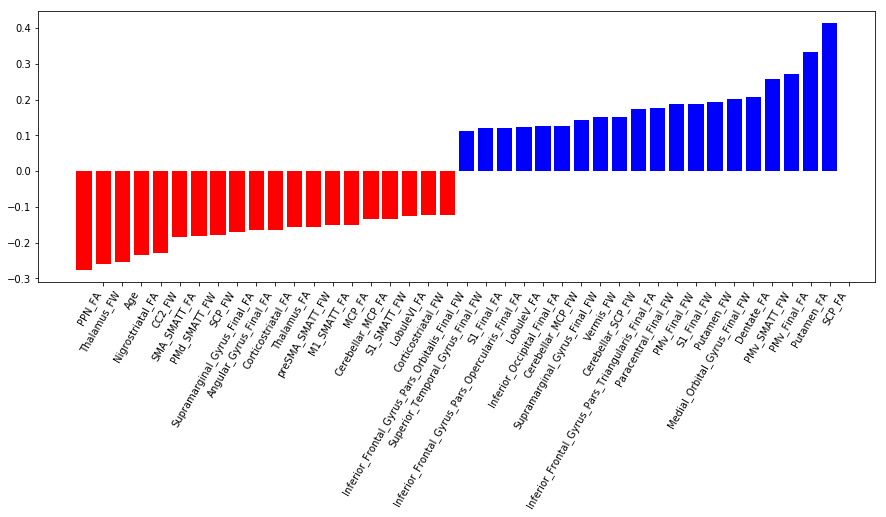

Age	-0.253330863513
Sex	-0.115779091447
aSN_FA	-0.0998851943277
Caudate_FA	0.0134162300212
CC2_FA	-0.0945595989248
GP_FA	-0.0357779977393
LobuleVI_FA	-0.124427508087
LobuleV_FA	0.124205922485
MCP_FA	-0.149552498455
pSN_FA	-0.101248860737
Putamen_FA	0.331847886485
SCP_FA	0.414463692271
STN_FA	-0.0709314783605
Thalamus_FA	-0.157086079106
Vermis_FA	-0.0398697008803
RN_FA	0.01139120464
PPN_FA	-0.276488235493
Dentate_FA	0.20636542196
CC1_FA	-0.0911694360187
aSN_FW	0.0404268098027
Caudate_FW	0.112474483628
CC2_FW	-0.230027403372
GP_FW	-0.0158219835412
LobuleVI_FW	0.016217215284
LobuleV_FW	-0.106550853793
MCP_FW	-0.055123463326
pSN_FW	-0.0952741246171
Putamen_FW	0.19473808263
SCP_FW	-0.179751120592
STN_FW	-0.0778841385494
Thalamus_FW	-0.25945276764
Vermis_FW	0.152076410974
RN_FW	-0.0211594141672
PPN_FW	-0.0445770859891
Dentate_FW	0.0323798490313
CC1_FW	0.0309118007641
Angular_Gyrus_Final_FA	-0.165125547947
Anterior_Orbital_Gyrus_Final_FA	0.0318199544321
Calcarine_Sulcus_Final_FA	0.02915385948

In [25]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.90      0.93      0.92        30
          1       0.83      0.77      0.80        13

avg / total       0.88      0.88      0.88        43

TESTING PROBABILITIES
1 0.983048526439
0 0.122606146314
0 0.395764804222
1 0.260695046756
1 0.866559478362
0 0.0877720652682
1 0.0450104810051
1 0.646860600013
0 0.0546900084655
0 0.798739133393
0 0.331421032
0 0.102740701725
0 0.431488667576
1 0.26544401638
1 0.942671825262
0 0.0129579288578
0 0.685184519741
0 0.0736923653257
0 0.123857850164
0 0.00627723431258
1 0.633988835814
0 0.0227743467444
0 0.264827290125
1 0.978165167964
0 0.0129685055768
0 0.14762939989
0 0.135813948283
0 0.454534774841
0 0.0225237814156
0 0.0708038204742
0 0.393304954529
1 0.893484198134
0 0.225632004021
1 0.98041501772
0 0.0231859102007
1 0.958315784413
0 0.0433715352417
0 0.196701077083
0 0.138014667644
0 0.034628741276
1 0.89089965879
0 0.0283459835922
0 0.303344762745


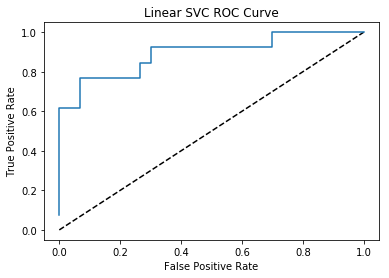

0.0 0.0769230769231
0.0 0.615384615385
0.0666666666667 0.615384615385
0.0666666666667 0.769230769231
0.266666666667 0.769230769231
0.266666666667 0.846153846154
0.3 0.846153846154
0.3 0.923076923077
0.7 0.923076923077
0.7 1.0
1.0 1.0


In [26]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)

In [27]:
import pickle
mod_name = 'no-updrs'
pickle.dump(best1, open('./models/%s/park_v_control.pkl' %mod_name, 'wb'))
pickle.dump(best2, open('./models/%s/pd_v_atypical.pkl' %mod_name, 'wb'))
pickle.dump(best3, open('./models/%s/msa_v_pd_psp.pkl' %mod_name, 'wb'))
pickle.dump(best4, open('./models/%s/psp_v_pd_msa.pkl' %mod_name, 'wb'))
pickle.dump(best5, open('./models/%s/psp_v_msa.pkl' %mod_name, 'wb'))